# Analysis of current model rewards

In [4]:
import pandas as pd
from pymongo import MongoClient
from datetime import datetime, timedelta

from steem import Steem
from steem.post import Post
from steembase.exceptions import PostDoesNotExist

import matplotlib.pyplot as plt

%matplotlib notebook

client = MongoClient('mongodb://107.155.87.82:26999')
# client = MongoClient('mongodb://localhost:26999')
db = client.get_database('steem')
db.authenticate("admin","dmw]SR%u6Ct!", source='admin')
past_votes_col = db.get_collection('past_votes')


steemd_instance = Steem(nodes=['https://api.steemit.com']).steemd

def get_percent_hr1(post):
#     sorted_votes = sorted(post.active_votes, key=lambda x: datetime.strptime(x['time'], '%Y-%m-%dT%H:%M:%S'))
    total_weight = 0
    hr1_weight = pd.np.nan
    hr1_strength = 0
    for vote in post.active_votes:
        weight = vote['weight']
        total_weight += weight
        
        if vote['voter'] == 'hr1':
            hr1_weight = weight
            hr1_strength = vote['percent']
    
    if hr1_weight is pd.np.nan:
        print(post.identifier)
        total_weight = 1
    
    if total_weight == 0:
        total_weight = 1 # all votes might be zero, but then hr1_weight must by NaN, so it's ok
    
    return hr1_weight / total_weight, hr1_strength

def get_payout_hr1(identifier):
    try:
        post = Post(identifier, steemd_instance=steemd_instance)
    except (TypeError, PostDoesNotExist):
        print("Doesn't exist: %s" % identifier)
        return pd.np.nan, pd.np.nan, pd.np.nan, pd.np.nan
    
    percent, strength = get_percent_hr1(post)
    
    if post.curator_payout_value > 0:
        # reward already paid out
        pending = False
        payout = post.curator_payout_value
        total_payout = post.reward + post.curator_payout_value
    else:
        # pending payout
        pending = True
        payout = post.pending_payout_value * 0.25 # curators get 25% from the post reward
        total_payout = post.pending_payout_value.amount # SBD
        
    return payout * percent, strength, pending, total_payout

def download_payouts_and_strengths(last_week_votes_df):
    now = datetime.utcnow()

    payouts_hr1 = []
    used_strength_hr1 = []
    is_pending = []
    total_payouts = []
    
    for i, identifier in enumerate(last_week_votes_df['_id']):
        if i % 50 == 0:
            print('%d (%d%%)' % (i, 100 * i / last_week_votes_df.shape[0]))

        payout_hr1, strength_hr1, pending, total_payout = get_payout_hr1(identifier)
        
        payouts_hr1.append(payout_hr1)
        used_strength_hr1.append(strength_hr1)
        is_pending.append(pending)
        total_payouts.append(total_payout)

    print('done')
    last_week_votes_df['strength'] = used_strength_hr1
    last_week_votes_df['hr1_%s' % now] = [float(x) for x in payouts_hr1]
    last_week_votes_df['pending'] = is_pending
    last_week_votes_df['total_payout'] = total_payouts
    
    return last_week_votes_df.dropna()

def get_payout_stats(last_week_votes_df, pending=None, days=None):
    
    print(datetime.utcnow(), '\n')
    
    if pending is not None:
        last_week_votes_df = last_week_votes_df[last_week_votes_df['pending'] == pending]
        
    if days:
        start_time = datetime.utcnow() - timedelta(days=days)
        last_week_votes_df = last_week_votes_df[last_week_votes_df['vote_time'] >= start_time]
        
        if start_time < start_time_model:
            time_diff = (datetime.utcnow() - start_time_model).total_seconds()
            time_diff = time_diff / 3600 / 24
        else:
            time_diff = days
    else:
        time_diff = (last_week_votes_df['vote_time'].max() - last_week_votes_df['vote_time'].min()).total_seconds()
        time_diff = time_diff / 3600 / 24
    
    last_col_name = last_week_votes_df.columns[-3]
#     last_col_name = last_week_votes_df.columns[-1]
    total_payout = last_week_votes_df[last_col_name].sum()
    
    avg_daily = total_payout / time_diff
    avg_weekly = avg_daily * 7
    avg_monthly = avg_weekly * 4
    avg_yearly = avg_monthly * 12
    
    print('Total payout in given period (%.1fd): %.3f SBD \t (avg. upvoted post payout: %.3f)' % 
          (time_diff, total_payout, last_week_votes_df.total_payout.mean()))
    print('Avg. daily payout: %.3f SBD' % (avg_daily))
    print('Avg. weekly payout: %.3f SBD' % (avg_weekly))
    print('Avg. monthly (28d) payout: %.3f SBD' % (avg_monthly))
    print('Avg. yearly (364d) payout: %.3f SBD' % (avg_yearly))

## Results for model deployed on 2017-12-17 20:33 UTC

In [25]:
# start_time_model = datetime.utcnow() - timedelta(days=7)
# start_time_model = datetime.strptime('2017-10-26T15:33', '%Y-%m-%dT%H:%M')
# start_time_model = datetime.strptime('2017-11-27T13:35', '%Y-%m-%dT%H:%M')
# start_time_model = datetime.strptime('2017-12-17T20:33', '%Y-%m-%dT%H:%M')
# start_time_model = datetime.strptime('2018-01-22T09:58', '%Y-%m-%dT%H:%M')

# start of vote-count experiment
# start_time_model = datetime.strptime('2018-03-02T17:10', '%Y-%m-%dT%H:%M')
# start_time_model = datetime.strptime('2018-03-10T20:57', '%Y-%m-%dT%H:%M')
start_time_model = datetime.strptime('2018-10-17T10:00', '%Y-%m-%dT%H:%M')
# start_time_model = datetime.utcnow() - timedelta(days=1)
last_week = {'$gte': start_time_model}
query = {'vote_time': last_week}
last_week_votes = past_votes_col.find(query).sort('vote_time')
last_week_votes_df = pd.DataFrame([x for x in last_week_votes])

In [26]:
last_week_votes_df.shape

(1961, 5)

In [7]:
# last_week_votes_df = last_week_votes_df[last_week_votes_df.index > 50000]

In [27]:
last_week_votes_df.head()

,_id,bid,percent,vote_time,voter
0,alexworld/0tmbx5d4,"{'from': 'alexworld', 'to': 'sureshot', 'amoun...",0.04,2018-10-17 10:02:43.735,hr1
1,kgakakillerg/legoland-shop-2018-10-17-04-57-19,"{'from': 'kgakakillerg', 'to': 'boomerang', 'a...",0.17,2018-10-17 10:05:06.182,hr1
2,andyluy/adsactly-em-adsactly-acreditando-em-cr...,"{'from': 'andyluy', 'to': 'minnowbooster', 'am...",5.60,2018-10-17 10:07:22.034,hr1
3,zielonepogotowie/te-rosliny-nadaja-sie-na-zywo...,"{'from': 'zielonepogotowie', 'to': 'mercurybot...",0.04,2018-10-17 10:10:17.388,hr1
4,lotto-austria/tipp-post-lotto-6-aus-45-fuer-mi...,"{'from': 'lotto-austria', 'to': 'boomerang', '...",0.28,2018-10-17 10:10:18.475,hr1


In [28]:
%%time
last_week_votes_df = download_payouts_and_strengths(last_week_votes_df)

0 (0%)
50 (2%)
100 (5%)
150 (7%)
200 (10%)
250 (12%)
300 (15%)
350 (17%)
400 (20%)
450 (22%)
500 (25%)
550 (28%)
600 (30%)
650 (33%)
700 (35%)
750 (38%)
800 (40%)
850 (43%)
900 (45%)
950 (48%)
1000 (50%)
1050 (53%)
1100 (56%)
1150 (58%)
1200 (61%)
1250 (63%)
1300 (66%)
1350 (68%)
1400 (71%)
1450 (73%)
1500 (76%)
1550 (79%)
1600 (81%)
1650 (84%)
1700 (86%)
1750 (89%)
1800 (91%)
1850 (94%)
1900 (96%)
1950 (99%)
done
CPU times: user 8.05 s, sys: 991 ms, total: 9.05 s
Wall time: 2min 40s


In [29]:
last_week_votes_df.shape

(1961, 9)

In [30]:
last_week_votes_df.head()

,_id,bid,percent,vote_time,voter,strength,hr1_2018-10-19 08:29:36.196028,pending,total_payout
0,alexworld/0tmbx5d4,"{'from': 'alexworld', 'to': 'sureshot', 'amoun...",0.04,2018-10-17 10:02:43.735,hr1,4,0.001885,True,1.497
1,kgakakillerg/legoland-shop-2018-10-17-04-57-19,"{'from': 'kgakakillerg', 'to': 'boomerang', 'a...",0.17,2018-10-17 10:05:06.182,hr1,17,0.002278,True,9.699
2,andyluy/adsactly-em-adsactly-acreditando-em-cr...,"{'from': 'andyluy', 'to': 'minnowbooster', 'am...",5.60,2018-10-17 10:07:22.034,hr1,560,0.382647,True,18.671
3,zielonepogotowie/te-rosliny-nadaja-sie-na-zywo...,"{'from': 'zielonepogotowie', 'to': 'mercurybot...",0.04,2018-10-17 10:10:17.388,hr1,4,0.000670,True,0.894
4,lotto-austria/tipp-post-lotto-6-aus-45-fuer-mi...,"{'from': 'lotto-austria', 'to': 'boomerang', '...",0.28,2018-10-17 10:10:18.475,hr1,28,0.006491,True,5.919


In [21]:
# myformat = 'YYYY-MM-DD HH:'
# start_time_model = datetime.strptime('2018-10-16T10:00', '%Y-%m-%dT%H:%M')
# last_day = datetime.strptime(myformat, '2018-10-16 20:00:35.652')
last_week_votes_df_one_day = last_week_votes_df[(last_week_votes_df['vote_time'] < (datetime.utcnow() - timedelta(hours=7)))
                                               & (last_week_votes_df['vote_time'] > (datetime.utcnow() - timedelta(hours=31)))]

<IPython.core.display.Javascript object>


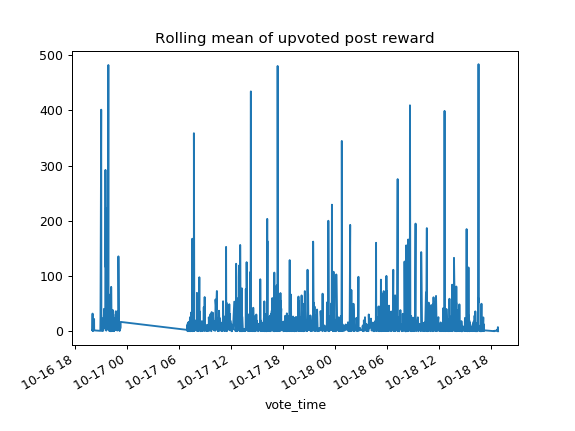

In [24]:
plt.figure()
last_week_votes_df.set_index('vote_time').total_payout.plot()
plt.title('Rolling mean of upvoted post reward');

<IPython.core.display.Javascript object>


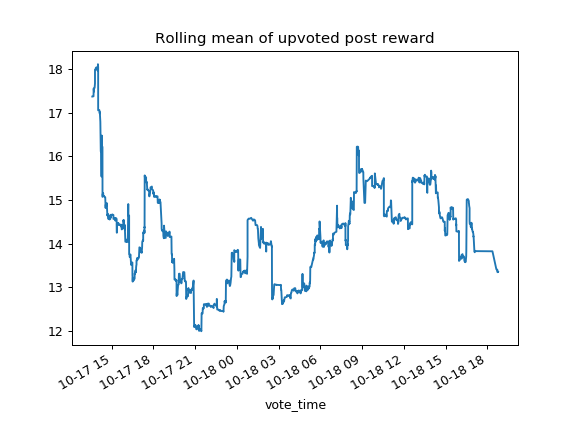

In [23]:
plt.figure()
last_week_votes_df.set_index('vote_time').total_payout.rolling(window=400).mean().plot()
plt.title('Rolling mean of upvoted post reward');

<IPython.core.display.Javascript object>


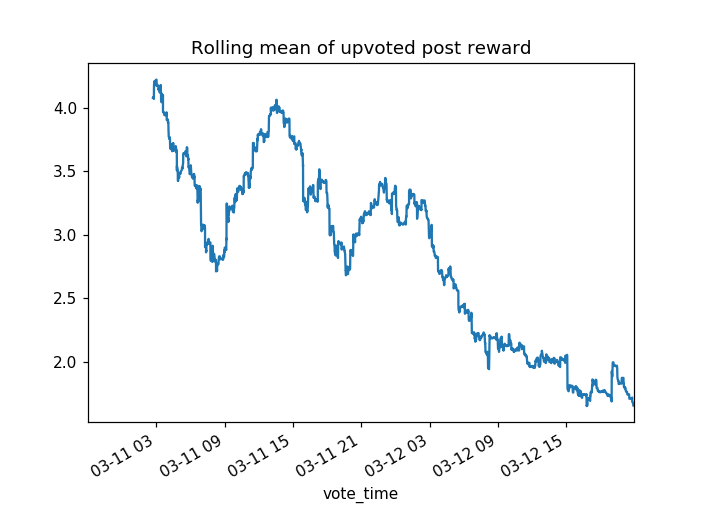

In [181]:
plt.figure()
last_week_votes_df.set_index('vote_time').total_payout.rolling(window=400).mean().plot()
plt.title('Rolling mean of upvoted post reward');

<IPython.core.display.Javascript object>


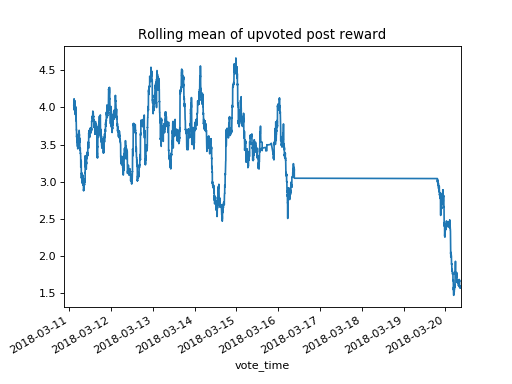

In [193]:
plt.figure()
last_week_votes_df.set_index('vote_time').total_payout.rolling(window=400).mean().plot()
plt.title('Rolling mean of upvoted post reward');

<IPython.core.display.Javascript object>


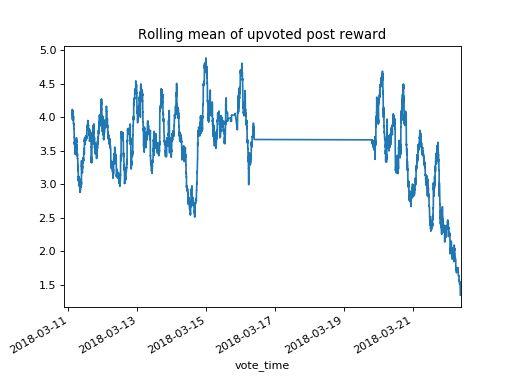

In [203]:
plt.figure()
last_week_votes_df.set_index('vote_time').total_payout.rolling(window=400).mean().plot()
plt.title('Rolling mean of upvoted post reward');

<IPython.core.display.Javascript object>


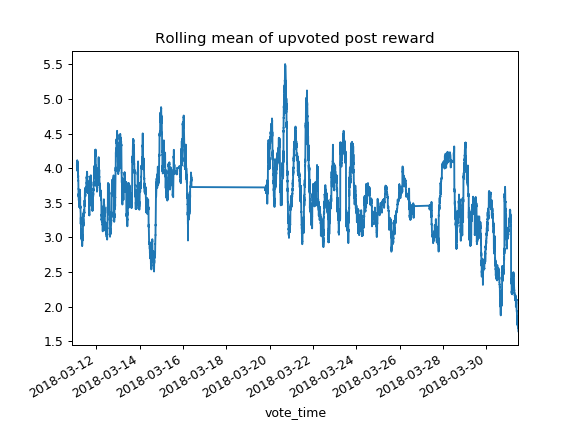

In [291]:
plt.figure()
last_week_votes_df.set_index('vote_time').total_payout.rolling(window=400).mean().plot()
plt.title('Rolling mean of upvoted post reward');

<IPython.core.display.Javascript object>


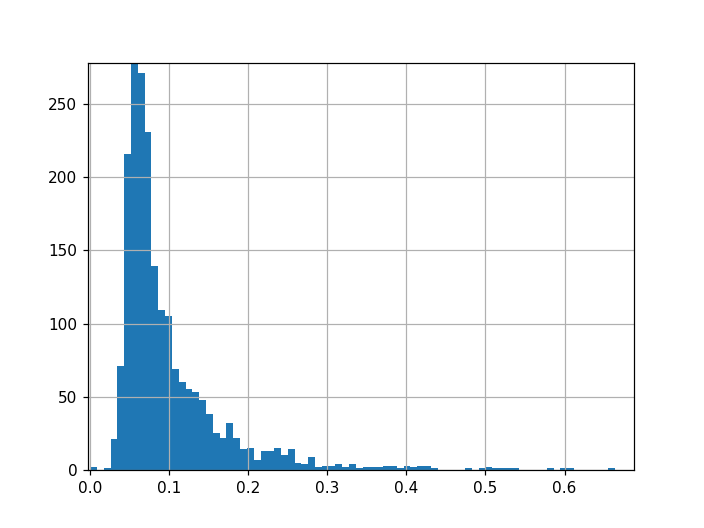

In [142]:
plt.figure()
last_week_votes_df.set_index('vote_time')['hr1_2018-03-12 14:12:56.511001'].hist(bins=100);

<IPython.core.display.Javascript object>


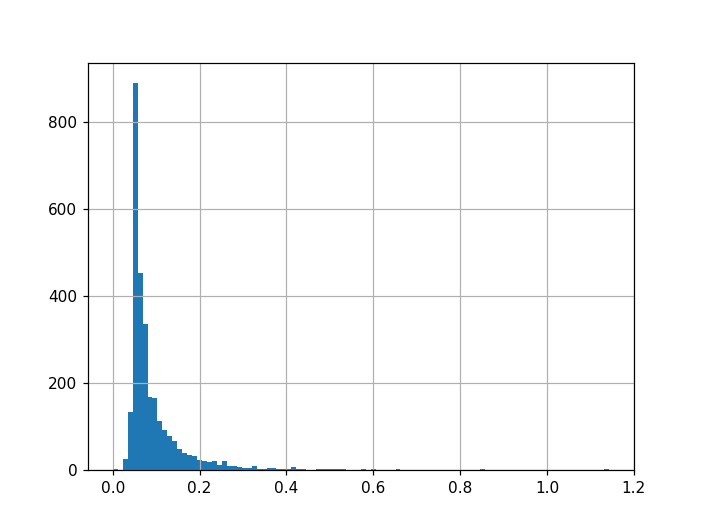

In [183]:
plt.figure()
last_week_votes_df.set_index('vote_time')['hr1_2018-03-12 20:55:44.884877'].hist(bins=100);

<IPython.core.display.Javascript object>


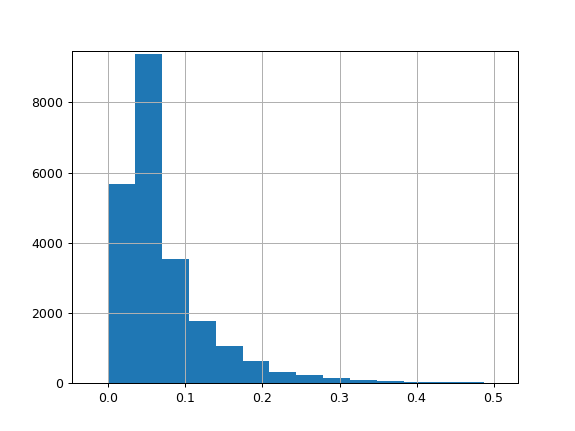

In [292]:
plt.figure()
last_week_votes_df.set_index('vote_time')['hr1_2018-03-31 13:34:06.968769'].hist(bins=100);

<IPython.core.display.Javascript object>


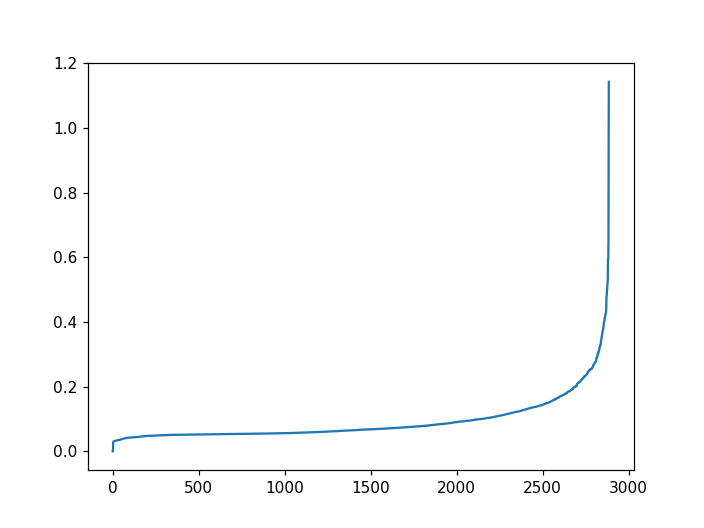

In [182]:
plt.figure()
hr1_payouts = last_week_votes_df['hr1_2018-03-12 20:55:44.884877'].sort_values().values
plt.plot(hr1_payouts);

<IPython.core.display.Javascript object>


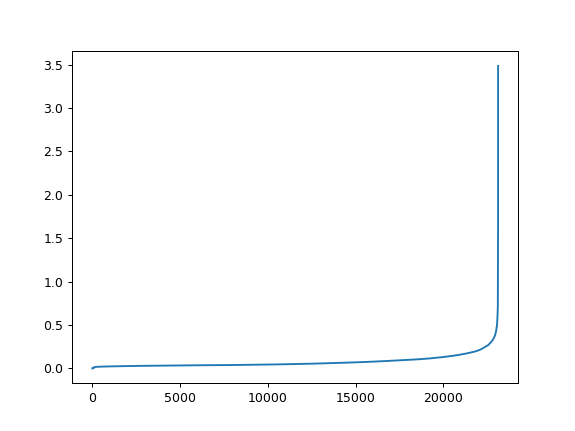

In [293]:
plt.figure()
hr1_payouts = last_week_votes_df['hr1_2018-03-31 13:34:06.968769'].sort_values().values
plt.plot(hr1_payouts);

In [149]:
last_week_votes_df.set_index('vote_time')['hr1_2018-03-12 14:12:56.511001'].mean()

0.091825239547724896

In [294]:
last_week_votes_df.set_index('vote_time')['hr1_2018-03-31 13:34:06.968769'].mean()

0.075485084851403914

#### Take the top 250 votes

In [160]:
hr1_payouts[-250:].mean()

0.2550384853716724

In [161]:
hr1_payouts[:-250].mean()

0.073633838987766417

#### Take 1/3 worst

In [169]:
hr1_payouts[:int(hr1_payouts.shape[0]/3)].mean()

0.050559492598856878

In [170]:
hr1_payouts[int(hr1_payouts.shape[0]/3):].mean()

0.11245811302215891

#### take hr1's upvote strength and multiply by curation share

- as if hr1 were the only voter

In [162]:
0.29 * 0.25

0.0725

In [165]:
last_week_votes_df[last_week_votes_df['hr1_2018-03-12 14:12:56.511001'] == last_week_votes_df['hr1_2018-03-12 14:12:56.511001'].max()]

,_id,net_votes,pending_payout_value,probability,vote_time,strength,hr1_2018-03-12 14:12:56.511001,pending,total_payout
2034,@knoxman/get-more-distance-when-casting-tips,3,"{'amount': 0.12, 'asset': 'SBD'}",0.628595,2018-03-11 20:02:22.153,2,0.86196,True,52.187


### Total rewards of current model

In [19]:
get_payout_stats(last_week_votes_df)

Total payout in given period (19.3d): 2727.423 SBD
Avg. daily payout: 141.178 SBD
Avg. weekly payout: 988.243 SBD
Avg. monthly (28d) payout: 3952.972 SBD
Avg. yearly (364d) payout: 47435.669 SBD


In [61]:
get_payout_stats(last_week_votes_df)

Total payout in given period (1.7d): 326.420 SBD
Avg. daily payout: 195.581 SBD
Avg. weekly payout: 1369.070 SBD
Avg. monthly (28d) payout: 5476.280 SBD
Avg. yearly (364d) payout: 65715.361 SBD


In [13]:
get_payout_stats(last_week_votes_df)

2018-01-24 11:02:14.292086 

Total payout in given period (2.0d): 434.093 SBD
Avg. daily payout: 213.063 SBD
Avg. weekly payout: 1491.440 SBD
Avg. monthly (28d) payout: 5965.759 SBD
Avg. yearly (364d) payout: 71589.103 SBD


In [40]:
get_payout_stats(last_week_votes_df)

2018-01-27 11:38:11.645900 

Total payout in given period (5.0d): 1537.994 SBD
Avg. daily payout: 306.144 SBD
Avg. weekly payout: 2143.006 SBD
Avg. monthly (28d) payout: 8572.024 SBD
Avg. yearly (364d) payout: 102864.291 SBD


In [40]:
get_payout_stats(last_week_votes_df)

2018-03-03 13:10:13.822957 

Total payout in given period (2.4d): 409.692 SBD
Avg. daily payout: 167.852 SBD
Avg. weekly payout: 1174.964 SBD
Avg. monthly (28d) payout: 4699.855 SBD
Avg. yearly (364d) payout: 56398.262 SBD


In [89]:
get_payout_stats(last_week_votes_df)

2018-03-03 13:50:30.982701 

Total payout in given period (2.5d): 506.522 SBD 	 (avg. upvoted post payout: 1.383)
Avg. daily payout: 201.536 SBD
Avg. weekly payout: 1410.749 SBD
Avg. monthly (28d) payout: 5642.996 SBD
Avg. yearly (364d) payout: 67715.951 SBD


In [108]:
get_payout_stats(last_week_votes_df)

2018-03-05 16:53:52.591682 

Total payout in given period (3.0d): 1025.081 SBD 	 (avg. upvoted post payout: 2.083)
Avg. daily payout: 347.287 SBD
Avg. weekly payout: 2431.011 SBD
Avg. monthly (28d) payout: 9724.045 SBD
Avg. yearly (364d) payout: 116688.541 SBD


In [123]:
get_payout_stats(last_week_votes_df)

2018-03-09 20:52:54.109058 

Total payout in given period (3.0d): 916.936 SBD 	 (avg. upvoted post payout: 2.236)
Avg. daily payout: 310.649 SBD
Avg. weekly payout: 2174.543 SBD
Avg. monthly (28d) payout: 8698.172 SBD
Avg. yearly (364d) payout: 104378.061 SBD


In [145]:
get_payout_stats(last_week_votes_df)

2018-03-12 15:27:18.021438 

Total payout in given period (1.7d): 228.920 SBD 	 (avg. upvoted post payout: 2.768)
Avg. daily payout: 133.342 SBD
Avg. weekly payout: 933.396 SBD
Avg. monthly (28d) payout: 3733.586 SBD
Avg. yearly (364d) payout: 44803.028 SBD


In [194]:
get_payout_stats(last_week_votes_df)

2018-03-22 08:57:31.021412 

Total payout in given period (9.5d): 693.542 SBD 	 (avg. upvoted post payout: 3.410)
Avg. daily payout: 73.035 SBD
Avg. weekly payout: 511.246 SBD
Avg. monthly (28d) payout: 2044.982 SBD
Avg. yearly (364d) payout: 24539.788 SBD


In [204]:
get_payout_stats(last_week_votes_df)

2018-03-22 09:41:24.042585 

Total payout in given period (11.5d): 1010.436 SBD 	 (avg. upvoted post payout: 3.477)
Avg. daily payout: 87.849 SBD
Avg. weekly payout: 614.942 SBD
Avg. monthly (28d) payout: 2459.767 SBD
Avg. yearly (364d) payout: 29517.206 SBD


In [295]:
get_payout_stats(last_week_votes_df)

2018-03-31 15:53:15.218417 

Total payout in given period (20.6d): 1745.819 SBD 	 (avg. upvoted post payout: 3.547)
Avg. daily payout: 84.725 SBD
Avg. weekly payout: 593.074 SBD
Avg. monthly (28d) payout: 2372.297 SBD
Avg. yearly (364d) payout: 28467.566 SBD


#### Bidbot

In [13]:
get_payout_stats(last_week_votes_df)

2018-10-18 18:51:41.718617 

Total payout in given period (1.9d): 80.812 SBD 	 (avg. upvoted post payout: 14.628)
Avg. daily payout: 41.472 SBD
Avg. weekly payout: 290.304 SBD
Avg. monthly (28d) payout: 1161.217 SBD
Avg. yearly (364d) payout: 13934.606 SBD


In [22]:
get_payout_stats(last_week_votes_df_one_day)

2018-10-18 19:05:18.290430 

Total payout in given period (1.0d): 52.243 SBD 	 (avg. upvoted post payout: 14.266)
Avg. daily payout: 52.325 SBD
Avg. weekly payout: 366.272 SBD
Avg. monthly (28d) payout: 1465.089 SBD
Avg. yearly (364d) payout: 17581.069 SBD


In [31]:
get_payout_stats(last_week_votes_df)

2018-10-19 08:32:45.412087 

Total payout in given period (1.9d): 93.160 SBD 	 (avg. upvoted post payout: 14.151)
Avg. daily payout: 48.168 SBD
Avg. weekly payout: 337.179 SBD
Avg. monthly (28d) payout: 1348.718 SBD
Avg. yearly (364d) payout: 16184.612 SBD


In [10]:
158.519 / 3.4

46.62323529411765

In [124]:
last_week_votes_df.shape[0] / 3

3100.6666666666665

In [126]:
last_week_votes_df.shape[0] * 2.236 / 3

6933.090666666667

### Only paid out rewards

In [62]:
get_payout_stats(last_week_votes_df, pending=False)

Total payout in given period (nand): 0.000 SBD
Avg. daily payout: nan SBD
Avg. weekly payout: nan SBD
Avg. monthly (28d) payout: nan SBD
Avg. yearly (364d) payout: nan SBD


In [195]:
get_payout_stats(last_week_votes_df, pending=False)

2018-03-22 08:58:00.713848 

Total payout in given period (2.5d): 280.649 SBD 	 (avg. upvoted post payout: 3.669)
Avg. daily payout: 111.131 SBD
Avg. weekly payout: 777.919 SBD
Avg. monthly (28d) payout: 3111.675 SBD
Avg. yearly (364d) payout: 37340.099 SBD


In [296]:
get_payout_stats(last_week_votes_df, pending=False)

2018-03-31 15:53:32.492357 

Total payout in given period (13.7d): 1203.189 SBD 	 (avg. upvoted post payout: 3.769)
Avg. daily payout: 87.685 SBD
Avg. weekly payout: 613.796 SBD
Avg. monthly (28d) payout: 2455.184 SBD
Avg. yearly (364d) payout: 29462.206 SBD


### Only pending rewards

In [21]:
get_payout_stats(last_week_votes_df, pending=True)

Total payout in given period (19.1d): 1014.689 SBD
Avg. daily payout: 53.248 SBD
Avg. weekly payout: 372.734 SBD
Avg. monthly (28d) payout: 1490.934 SBD
Avg. yearly (364d) payout: 17891.208 SBD


In [52]:
get_payout_stats(last_week_votes_df, pending=True)

Total payout in given period (1.0d): 214.473 SBD
Avg. daily payout: 206.899 SBD
Avg. weekly payout: 1448.291 SBD
Avg. monthly (28d) payout: 5793.162 SBD
Avg. yearly (364d) payout: 69517.949 SBD


In [297]:
get_payout_stats(last_week_votes_df, pending=True)

2018-03-31 15:53:48.503996 

Total payout in given period (20.6d): 542.630 SBD 	 (avg. upvoted post payout: 3.071)
Avg. daily payout: 26.355 SBD
Avg. weekly payout: 184.488 SBD
Avg. monthly (28d) payout: 737.952 SBD
Avg. yearly (364d) payout: 8855.424 SBD


### Total rewards for votes made in last N days

In [22]:
get_payout_stats(last_week_votes_df, days=1)

Total payout in given period (1.0d): 129.092 SBD
Avg. daily payout: 130.291 SBD
Avg. weekly payout: 912.039 SBD
Avg. monthly (28d) payout: 3648.156 SBD
Avg. yearly (364d) payout: 43777.868 SBD


In [63]:
get_payout_stats(last_week_votes_df, days=1)

Total payout in given period (1.0d): 168.559 SBD
Avg. daily payout: 171.005 SBD
Avg. weekly payout: 1197.034 SBD
Avg. monthly (28d) payout: 4788.135 SBD
Avg. yearly (364d) payout: 57457.615 SBD


In [14]:
get_payout_stats(last_week_votes_df, days=1)

2018-01-24 11:02:34.415241 

Total payout in given period (1.0d): 231.134 SBD
Avg. daily payout: 232.846 SBD
Avg. weekly payout: 1629.919 SBD
Avg. monthly (28d) payout: 6519.674 SBD
Avg. yearly (364d) payout: 78236.090 SBD


In [36]:
get_payout_stats(last_week_votes_df, days=1)

2018-01-27 11:36:17.510512 

Total payout in given period (1.0d): 283.883 SBD
Avg. daily payout: 283.883 SBD
Avg. weekly payout: 1987.180 SBD
Avg. monthly (28d) payout: 7948.721 SBD
Avg. yearly (364d) payout: 95384.649 SBD


In [109]:
get_payout_stats(last_week_votes_df, days=1)

2018-03-05 17:32:22.011318 

Total payout in given period (1.0d): 161.900 SBD 	 (avg. upvoted post payout: 1.517)
Avg. daily payout: 161.900 SBD
Avg. weekly payout: 1133.297 SBD
Avg. monthly (28d) payout: 4533.190 SBD
Avg. yearly (364d) payout: 54398.276 SBD


In [146]:
get_payout_stats(last_week_votes_df, days=1)

2018-03-12 15:28:19.462373 

Total payout in given period (1.0d): 112.899 SBD 	 (avg. upvoted post payout: 2.220)
Avg. daily payout: 112.899 SBD
Avg. weekly payout: 790.294 SBD
Avg. monthly (28d) payout: 3161.177 SBD
Avg. yearly (364d) payout: 37934.124 SBD


In [298]:
get_payout_stats(last_week_votes_df, days=1)

2018-03-31 15:54:23.250304 

Total payout in given period (1.0d): 79.468 SBD 	 (avg. upvoted post payout: 2.522)
Avg. daily payout: 79.468 SBD
Avg. weekly payout: 556.276 SBD
Avg. monthly (28d) payout: 2225.106 SBD
Avg. yearly (364d) payout: 26701.271 SBD


In [23]:
get_payout_stats(last_week_votes_df, days=2)

Total payout in given period (2.0d): 263.789 SBD
Avg. daily payout: 132.517 SBD
Avg. weekly payout: 927.619 SBD
Avg. monthly (28d) payout: 3710.476 SBD
Avg. yearly (364d) payout: 44525.706 SBD


In [64]:
get_payout_stats(last_week_votes_df, days=2)

Total payout in given period (1.7d): 326.420 SBD
Avg. daily payout: 195.581 SBD
Avg. weekly payout: 1369.070 SBD
Avg. monthly (28d) payout: 5476.280 SBD
Avg. yearly (364d) payout: 65715.361 SBD


In [15]:
get_payout_stats(last_week_votes_df, days=2)

2018-01-24 11:03:00.281183 

Total payout in given period (2.0d): 422.865 SBD
Avg. daily payout: 212.260 SBD
Avg. weekly payout: 1485.818 SBD
Avg. monthly (28d) payout: 5943.273 SBD
Avg. yearly (364d) payout: 71319.274 SBD


In [37]:
get_payout_stats(last_week_votes_df, days=2)

2018-01-27 11:36:35.489545 

Total payout in given period (2.0d): 653.360 SBD
Avg. daily payout: 326.680 SBD
Avg. weekly payout: 2286.761 SBD
Avg. monthly (28d) payout: 9147.044 SBD
Avg. yearly (364d) payout: 109764.528 SBD


In [147]:
get_payout_stats(last_week_votes_df, days=2)

2018-03-12 15:28:44.870036 

Total payout in given period (1.8d): 228.920 SBD 	 (avg. upvoted post payout: 2.768)
Avg. daily payout: 129.184 SBD
Avg. weekly payout: 904.289 SBD
Avg. monthly (28d) payout: 3617.155 SBD
Avg. yearly (364d) payout: 43405.859 SBD


In [299]:
get_payout_stats(last_week_votes_df, days=2)

2018-03-31 15:54:30.692817 

Total payout in given period (2.0d): 205.962 SBD 	 (avg. upvoted post payout: 2.619)
Avg. daily payout: 102.981 SBD
Avg. weekly payout: 720.866 SBD
Avg. monthly (28d) payout: 2883.466 SBD
Avg. yearly (364d) payout: 34601.591 SBD


In [24]:
get_payout_stats(last_week_votes_df, days=3)

Total payout in given period (3.0d): 395.534 SBD
Avg. daily payout: 132.224 SBD
Avg. weekly payout: 925.571 SBD
Avg. monthly (28d) payout: 3702.286 SBD
Avg. yearly (364d) payout: 44427.431 SBD


In [44]:
get_payout_stats(last_week_votes_df, days=3)

2018-01-27 11:44:04.014245 

Total payout in given period (3.0d): 821.864 SBD
Avg. daily payout: 273.955 SBD
Avg. weekly payout: 1917.682 SBD
Avg. monthly (28d) payout: 7670.729 SBD
Avg. yearly (364d) payout: 92048.748 SBD


In [300]:
get_payout_stats(last_week_votes_df, days=3)

2018-03-31 15:54:37.506852 

Total payout in given period (3.0d): 342.763 SBD 	 (avg. upvoted post payout: 2.905)
Avg. daily payout: 114.254 SBD
Avg. weekly payout: 799.781 SBD
Avg. monthly (28d) payout: 3199.123 SBD
Avg. yearly (364d) payout: 38389.472 SBD


In [25]:
get_payout_stats(last_week_votes_df, days=7)

Total payout in given period (7.0d): 1017.376 SBD
Avg. daily payout: 145.535 SBD
Avg. weekly payout: 1018.745 SBD
Avg. monthly (28d) payout: 4074.981 SBD
Avg. yearly (364d) payout: 48899.773 SBD


In [43]:
get_payout_stats(last_week_votes_df, days=7)

2018-01-27 11:43:39.504763 

Total payout in given period (5.1d): 1537.994 SBD
Avg. daily payout: 303.150 SBD
Avg. weekly payout: 2122.051 SBD
Avg. monthly (28d) payout: 8488.204 SBD
Avg. yearly (364d) payout: 101858.449 SBD


In [301]:
get_payout_stats(last_week_votes_df, days=7)

2018-03-31 15:54:43.102774 

Total payout in given period (7.0d): 538.744 SBD 	 (avg. upvoted post payout: 3.090)
Avg. daily payout: 76.963 SBD
Avg. weekly payout: 538.744 SBD
Avg. monthly (28d) payout: 2154.974 SBD
Avg. yearly (364d) payout: 25859.692 SBD
